# Forecasting with Moving Averages and Autoregressive Models

In [78]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
from arch.unitroot import ADF, KPSS
from pmdarima.arima.utils import ndiffs
from sklearn import metrics
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)
df = yf.download("SPY", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


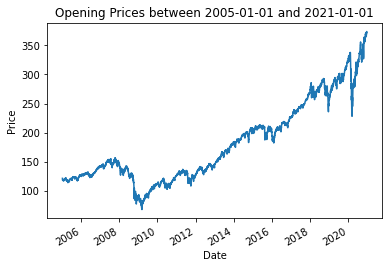

In [6]:
plt.title(
    "Opening Prices between {} and {}".format(
        start_date.date().isoformat(), end_date.date().isoformat()
    )
)
df["Open"].plot()
plt.ylabel("Price")
plt.xlabel("Date");

In [14]:
df1 = df.reset_index().resample("W", on="Date")["Open"].mean()
df1 = df1[df1.index.isocalendar().week < 53]
df1

Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
                 ...    
2020-11-29    361.114998
2020-12-06    365.444000
2020-12-13    367.577997
2020-12-20    369.754004
2020-12-27    367.384995
Name: Open, Length: 832, dtype: float64

In [15]:
df1 = df1.asfreq("W").fillna(method="ffill")

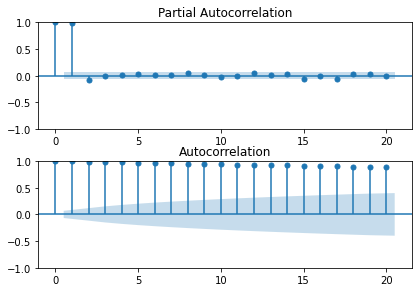

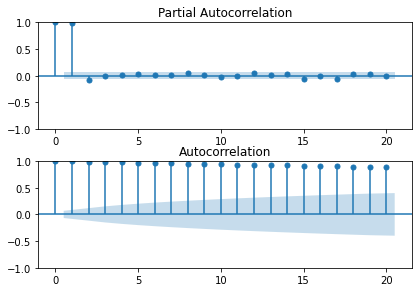

In [23]:
fig, axs = plt.subplots(2)
fig.tight_layout()
sm.graphics.tsa.plot_pacf(df1, lags=20, ax=axs[0], method="ywm")
sm.graphics.tsa.plot_acf(df1, lags=20, ax=axs[1])

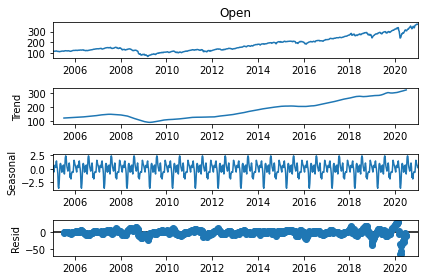

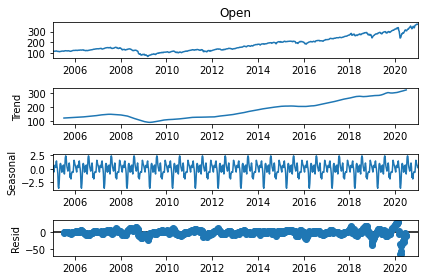

In [36]:
result = seasonal_decompose(df1, model="additive", period=52)
result.plot()

In [37]:
ADF(df1)

Test Statistic,1.325
P-value,0.997
Lags,9


In [40]:
ndiffs(df1, test="adf")

1

In [51]:
mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(1, 1, 0)))
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1968.256
Date:                Thu, 18 Aug 2022   AIC                           3940.513
Time:                        17:01:48   BIC                           3949.963
Sample:                    01-09-2005   HQIC                          3944.136
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2583      0.022     11.770      0.000       0.215       0.301
sigma2         6.6045      0.186     35.513      0.000       6.240       6.969
Ljung-Box (L1) (Q):                   0.07   Jarque-

In [52]:
STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame()

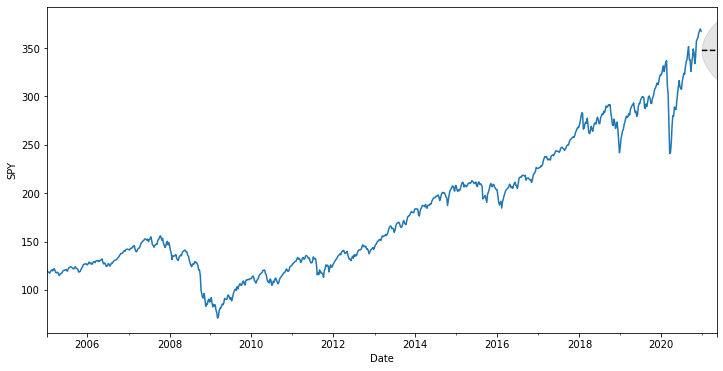

In [53]:
ax = df1.plot(figsize=(12, 6))
plt.ylabel("SPY")
forecasts_df["mean"].plot(style="k--")
ax.fill_between(
    forecasts_df.index,
    forecasts_df["mean_ci_lower"],
    forecasts_df["mean_ci_upper"],
    color="k",
    alpha=0.1,
)

In [65]:
forecasts = []
qs = []
for q in range(0, 30, 10):
    mod = STLForecast(
        df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(0, 1, q), trend="t")
    )
    res = mod.fit().model_result
    print(f"aic ({q}): {res.aic}")
    forecasts.append(res.get_forecast(steps=STEPS).summary_frame()["mean"])
    qs.append(q)
forecasts_df = pd.concat(forecasts, axis=1)
forecasts_df.columns = qs

aic (0): 3989.0104184919173
aic (10): 3934.3759092634064
aic (20): 3935.3355340839007


<AxesSubplot:xlabel='Date', ylabel='SPY'>

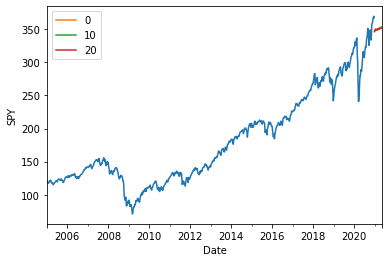

In [66]:
ax = df1.plot()
plt.ylabel("SPY")
forecasts_df.plot(ax=ax)

In [70]:
mod = sm.tsa.ExponentialSmoothing(endog=df1, trend="add")
res = mod.fit()

<AxesSubplot:xlabel='Date', ylabel='SPY'>

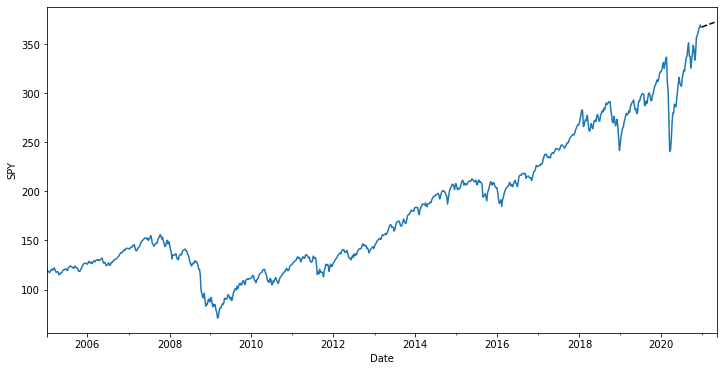

In [73]:
forecasts = pd.Series(res.forecast(steps=STEPS))
ax = df1.plot(figsize=(12, 6))
plt.ylabel("SPY")
forecasts.plot(style="k--")

In [76]:
train_length = int(len(df1) * 0.8)
tm = ThetaModel(df1[:train_length], method="auto", deseasonalize=True)

<AxesSubplot:xlabel='Date', ylabel='SPY'>

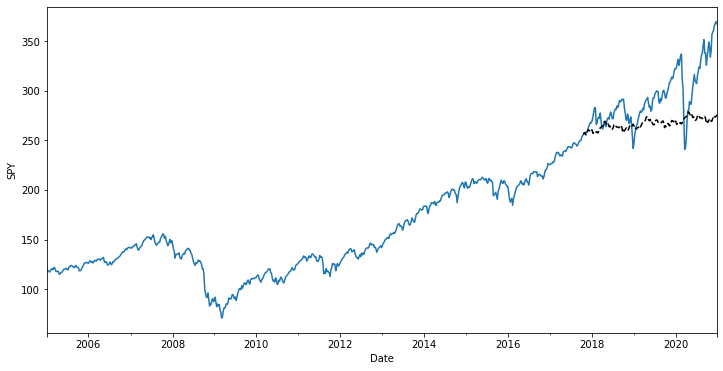

In [77]:
res = tm.fit()
forecasts = res.forecast(steps=len(df1) - train_length)
ax = df1.plot(figsize=(12, 6))
plt.ylabel("SPY")
forecasts.plot(style="k--")

In [79]:
metrics.mean_squared_error(forecasts, df1[train_length:], squared=False)

37.03323186321104